<a href="https://colab.research.google.com/github/WellFan/bayesian_with_merchants/blob/main/merchants_goods_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import special
from scipy import stats
import stan
import arviz as az
!pip install nest_asyncio
import nest_asyncio
nest_asyncio.apply()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


---

Consider the following model:

$\mu_i\sim Beta(\alpha_u, \beta_u)\\
trial_i\sim Gamma(10,10)$


With parameter tranformation:

$\alpha_i=\mu_i*trial_i\\
\beta_i=(1-\mu_i)*trial_i$

The relation between datas and parameters:

$ctr_{ij}\sim Beta(\alpha_i, \beta_i)\\
click_{ij}\sim Bin(impression_{ij}, ctr_{ij})$

Let i denote the i'th merchant, let (i,j) denote the j'th kind of goods from i'th merchant

---

In [37]:
nmerchants = 100
ngoods = np.random.randint(low=1, high=101, size=nmerchants)
alpha_u = 2
beta_u = 98
mu_i = stats.beta.rvs(alpha_u, beta_u, size=nmerchants)
trial = stats.gamma.rvs(10, scale=10, size=nmerchants)
true_parameters = {'alpha_u':alpha_u, 'beta_u':beta_u, 'mu_i':mu_i, 'trial':trial, 'ngoods':ngoods, 'alpha_i':mu_i*trial, 'beta_i':(1-mu_i)*trial}
data = np.array(([0], [0], [0], [0]))
for i in range(nmerchants):
  ctr = np.array(stats.beta.rvs(mu_i[i]*trial[i], (1-mu_i[i])*trial[i], size=ngoods[i]))
  impression = np.random.randint(low=1, high=101, size=ngoods[i])
  click = np.array(stats.binom.rvs(impression, ctr))
  merchants_id = np.array([i]*ngoods[i])
  temp = (np.vstack((merchants_id, ctr, impression, click)))
  data = np.hstack((data, temp))
data = np.transpose(data)
data = np.delete(data, 0, 0)

In [38]:
data = np.delete(data, 0, 0)
data.shape

(4673, 4)

In [39]:
text='''
data{
  int<lower=0> N;
  int<lower=0> M;
  int<lower=1, upper=100> type[N];
  int<lower=0> impression[N];
  int<lower=0> click[N];
}
parameters{
  vector<lower=0.01, upper=1>[M] mu;
  vector<lower=0>[M] trial;
  real<lower=0> alpha_u;
  real<lower=0> beta_u;
}
transformed parameters{
  vector[M] alpha_i;
  vector[M] beta_i;
  alpha_i = mu.*trial;
  beta_i = (1-mu).*trial;
}
model{
  alpha_u~uniform(0.01, 100);
  beta_u~uniform(0.01, 100);
  mu~beta(alpha_u, beta_u);
  trial~gamma(10, 0.1);
  for(i in 1:N) {
    click[i]~beta_binomial(impression[i], alpha_i[type[i]], beta_i[type[i]]);
  }
}
'''
stan_data = {'N':data.shape[0], 'M':nmerchants, 'type': list(data[:,0].astype('int')+1), 'impression': list(data[:,2].astype('int')), 'click': list(data[:,3].astype('int'))}
posterior = stan.build(text, data=stan_data)
fit = posterior.sample(num_chains=1, num_samples=500)
df = fit.to_frame()

Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_jbyc0rgw/model_7oojran7.stan', line 23, column 23: Argument 100 suggests there may be parameters that are not unit scale; consider rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_jbyc0rgw/model_7oojran7.stan', line 23, column 17: Argument 0.01 suggests there may be parameters that are not unit scale; consider rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_jbyc0rgw/model_7oojran7.stan', line 23, column 2: Parameter beta_u is given a uniform distribution. The uniform distribution is not recommended, for two reasons: (a) Except when there are logical or physical constraints, it is very unusual for you to be sure that a parameter will fall inside a specified range, and (b) The infinite gradient induced by a uniform density can cause difficulties for Stan's sampling algorithm. As a consequence, we recommend soft constraints rather than hard cons

In [40]:
df.head()

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,mu.1,mu.2,mu.3,...,beta_i.91,beta_i.92,beta_i.93,beta_i.94,beta_i.95,beta_i.96,beta_i.97,beta_i.98,beta_i.99,beta_i.100
draws,,,,,,,,,,,,,,,,,,,,,
0,-17764.325022,0.936730,0.138349,4.0,16.0,1.0,17858.344041,0.011014,0.020761,0.010749,...,34.260714,57.248261,118.909457,79.056886,124.164381,62.710411,43.525451,54.795302,128.166572,64.484882
1,-17767.612252,0.744105,0.138349,2.0,5.0,1.0,17861.549130,0.010832,0.021390,0.010609,...,32.543562,59.495954,116.936528,77.682381,110.064727,54.056801,45.875562,56.311710,124.006082,73.408687
2,-17768.217946,0.752630,0.138349,2.0,7.0,1.0,17865.681749,0.010751,0.021164,0.010540,...,33.430812,64.803825,111.536661,74.440505,112.880292,52.798112,50.575083,54.539155,126.694315,77.657269
3,-17768.352288,0.816452,0.138349,2.0,6.0,1.0,17866.648678,0.010603,0.020474,0.010532,...,34.772439,65.616973,82.997255,90.528873,99.155886,42.545929,50.661863,57.344960,136.105027,72.698278
4,-17769.609054,0.666667,0.138349,1.0,3.0,1.0,17868.630187,0.010535,0.019376,0.010547,...,34.566139,64.327786,89.968302,83.217941,103.822845,39.750492,51.955211,56.212857,144.198558,74.184411


---

After the estimation, Stan brings lots of draws of $\hat{\alpha_u},\hat{\beta_u},\hat{\mu_i},\hat{trial_i}$

And from sample distribution

$\hat{\alpha_u}\stackrel{p}{\to}\alpha_u\\
\hat{\beta_u}\stackrel{p}{\to}\beta_u\\
\bar{\hat{\mu_i}}\stackrel{p}{\to}\mu_i\sim Beta(\alpha_\mu, \beta_\mu)\\
\bar{\hat{trial_i}}\stackrel{p}{\to}trial_i\sim Gamma(10, 10)$

---

In [41]:
df.iloc[:,107:207].mean()

parameters
trial.1      106.535111
trial.2       98.213730
trial.3       97.558459
trial.4      108.432780
trial.5      102.590552
                ...    
trial.96      69.240015
trial.97      50.704562
trial.98     116.039680
trial.99     109.149319
trial.100     84.502060
Length: 100, dtype: float64

In [42]:
alpha_u = df['alpha_u']
beta_u = df['beta_u']
mu = df.iloc[:,7:107]
trial = df.iloc[:,107:207]
alpha_i = df.iloc[:, 209:309]
beta_i = df.iloc[:, 309:409]

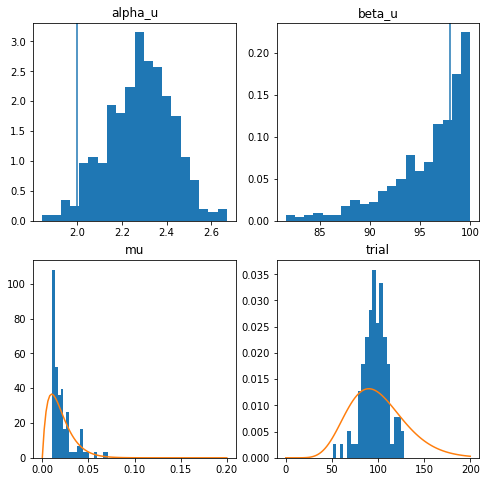

In [64]:
points = np.linspace(0, 100, 1001, endpoint=True)
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
axes[0,0].set_title('alpha_u')
axes[0,0].hist(alpha_u, density=True, bins=20)
axes[0,0].axvline(2)
axes[0,1].set_title('beta_u')
axes[0,1].hist(beta_u, density=True, bins=20)
axes[0,1].axvline(98)
axes[1,0].set_title('mu')
axes[1,0].hist(mu.mean(), density=True, bins=20)
axes[1,0].plot(np.linspace(0, 0.2, 100), stats.beta.pdf(np.linspace(0, 0.2, 100), 2, 98))
axes[1,1].set_title('trial')
axes[1,1].hist(trial.mean(), density=True, bins=20)
axes[1,1].plot(np.linspace(0, 200, 100), stats.gamma.pdf(np.linspace(0, 200, 100), a=10, scale=10))

In [44]:
customer_stan = pd.DataFrame(data, columns=['merchant_id', 'ctr', 'impression', 'click'])
customer_stan = customer_stan.astype({'merchant_id':int, 'impression':int, 'click':int})
customer_stan.head()

,merchant_id,ctr,impression,click
0,0,0.028725,8,0
1,0,0.005155,95,1
2,0,0.001770,43,0
3,0,0.018357,16,1
4,0,0.000416,85,0


In [45]:
customer_stan['alpha_i'] = alpha_i.mean()[customer_stan.merchant_id][1]
customer_stan['beta_i'] = beta_i.mean()[customer_stan.merchant_id][1]
customer_stan = customer_stan.assign(avg_stan = lambda df:(df.click+df.alpha_i)/(df.impression+df.alpha_i+df.beta_i))
customer_stan.head()

,merchant_id,ctr,impression,click,alpha_i,beta_i,avg_stan
0,0,0.028725,8,0,1.200196,105.334915,0.010479
1,0,0.005155,95,1,1.200196,105.334915,0.010917
2,0,0.001770,43,0,1.200196,105.334915,0.008026
3,0,0.018357,16,1,1.200196,105.334915,0.017956
4,0,0.000416,85,0,1.200196,105.334915,0.006266


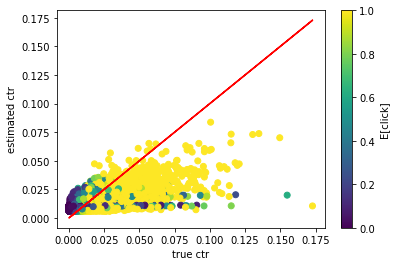

In [46]:
plt.scatter(customer_stan.ctr, customer_stan.avg_stan, c=customer_stan.impression*customer_stan.ctr, cmap='viridis', vmin=0, vmax=1)
plt.plot(customer_stan.ctr, customer_stan.ctr, color='red')
plt.xlabel('true ctr')
plt.ylabel('estimated ctr')
plt.colorbar(label='E[click]')
plt.show()

In [47]:
customer_stan.ctr.corr(customer_stan.avg_stan)

0.6642590463408375

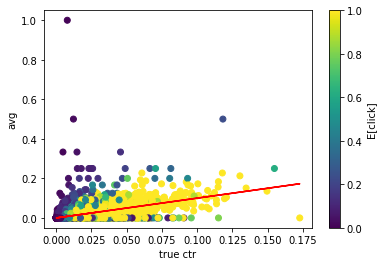

In [48]:
plt.scatter(customer_stan.ctr, customer_stan.click/customer_stan.impression, c=customer_stan.impression*customer_stan.ctr, cmap='viridis', vmin=0, vmax=1)
plt.plot(customer_stan.ctr, customer_stan.ctr, color='red')
plt.xlabel('true ctr')
plt.ylabel('avg')
plt.colorbar(label='E[click]')
plt.show()

In [85]:
print('MSE of estimated ctr per goods', np.square(customer_stan.ctr-customer_stan.avg_stan).mean())
print('MSE of average ctr per goods', np.square(customer_stan.ctr-(customer_stan.click/customer_stan.impression)).mean())

MSE of estimated ctr per goods 0.0002671769800440823
MSE of average ctr per goods 0.0009940059926839815


In [80]:
impression_per_merchants  = customer_stan.groupby(['merchant_id']).agg({'impression':sum, 'click':sum})['impression']
click_per_merchants  = customer_stan.groupby(['merchant_id']).agg({'impression':sum, 'click':sum})['click']

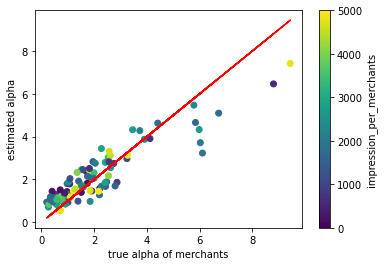

In [68]:
plt.scatter(true_parameters['alpha_i'], alpha_i.mean(),c=impression_per_merchants, cmap='viridis', vmin=0, vmax=5000)
plt.plot(true_parameters['alpha_i'], true_parameters['alpha_i'], color='red')
plt.xlabel('true alpha of merchants')
plt.ylabel('estimated alpha')
plt.colorbar(label='impression_per_merchants')
plt.show()

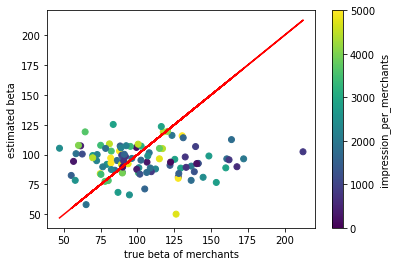

In [67]:
plt.scatter(true_parameters['beta_i'], beta_i.mean(), c=impression_per_merchants, cmap='viridis', vmin=0, vmax=5000)
plt.plot(true_parameters['beta_i'], true_parameters['beta_i'], color='red')
plt.xlabel('true beta of merchants')
plt.ylabel('estimated beta')
plt.colorbar(label='impression_per_merchants')
plt.show()

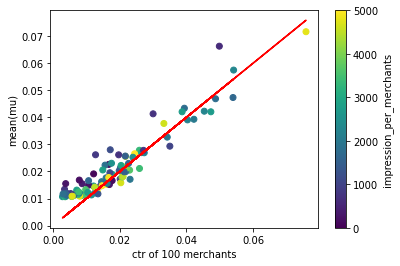

In [69]:
plt.scatter(true_parameters['mu_i'], mu.mean(), c=impression_per_merchants, cmap='viridis', vmin=0, vmax=5000)
plt.plot(true_parameters['mu_i'], true_parameters['mu_i'], color='red')
plt.xlabel('ctr of 100 merchants')
plt.ylabel('mean(mu)')
plt.colorbar(label='impression_per_merchants')
plt.show()

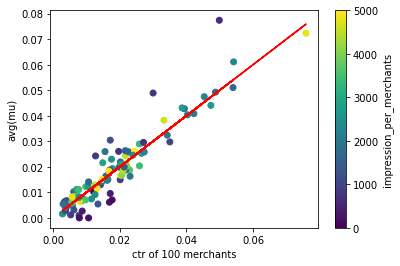

In [81]:
plt.scatter(true_parameters['mu_i'], click_per_merchants/impression_per_merchants, c=impression_per_merchants, cmap='viridis', vmin=0, vmax=5000)
plt.plot(true_parameters['mu_i'], true_parameters['mu_i'], color='red')
plt.xlabel('ctr of 100 merchants')
plt.ylabel('avg(mu)')
plt.colorbar(label='impression_per_merchants')
plt.show()

In [83]:
print('MSE of estimated ctr per merchants', np.square(true_parameters['mu_i']-mu.mean()).mean())
print('MSE of average ctr per merchants', np.square(true_parameters['mu_i']-click_per_merchants/impression_per_merchants).mean())

MSE of estimated ctr per merchants 2.5871893433221065e-05
MSE of average ctr per merchants 2.863526894024459e-05


---

Figure 1&2 compares tradional way to compute the ctr with the bayesian way.
The bayesian does better esimate the ctr when the expectation is low.
Intuitively, the prior that baysian gives makes a better fit when our observations is rather low.
Hence we have a default belief about how the good is when we see a new kind.

---

If we neglect the difference between merchants:

$ctr_i\sim Betabinomial(impression_i, \alpha,\beta)$

---

In [14]:
text2='''
data{
  int<lower=0> N;
  int<lower=0> impression[N];
  int<lower=0> click[N];
}
parameters{
  real<lower=0> alpha;
  real<lower=0> beta;
}
model{
  alpha~uniform(0.01, 100);
  beta~uniform(0.01, 100);
  click~beta_binomial(impression, alpha, beta);
}
'''
stan_data = {'N':data.shape[0], 'impression': list(data[:,2].astype('int')), 'click': list(data[:,3].astype('int'))}
posterior = stan.build(text2, data=stan_data)
fit = posterior.sample(num_chains=1, num_samples=500)
df_nomerchant = fit.to_frame()

Building...



Building: 37.7s, done.Messages from stanc:
Warning in '/tmp/httpstan_t4dfdqje/model_mrjqfvrf.stan', line 13, column 21: Argument 100 suggests there may be parameters that are not unit scale; consider rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_t4dfdqje/model_mrjqfvrf.stan', line 13, column 15: Argument 0.01 suggests there may be parameters that are not unit scale; consider rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_t4dfdqje/model_mrjqfvrf.stan', line 13, column 2: Parameter beta is given a uniform distribution. The uniform distribution is not recommended, for two reasons: (a) Except when there are logical or physical constraints, it is very unusual for you to be sure that a parameter will fall inside a specified range, and (b) The infinite gradient induced by a uniform density can cause difficulties for Stan's sampling algorithm. As a consequence, we recommend soft constraints rather than hard constraints; fo

In [15]:
df_nomerchant.head()

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,alpha,beta
draws,,,,,,,,,
0,-24942.218001,0.878978,0.350235,2.0,3.0,0.0,24942.956373,0.921519,43.503258
1,-24941.806524,0.980923,0.350235,2.0,3.0,0.0,24942.330127,0.927007,42.804910
2,-24942.187313,0.582589,0.350235,2.0,3.0,0.0,24945.458236,0.932619,43.918621
3,-24941.995128,0.952927,0.350235,2.0,3.0,0.0,24942.560381,0.933192,43.679093
4,-24943.512490,0.966159,0.350235,3.0,11.0,0.0,24945.447722,0.853563,38.591040


In [16]:
alpha_true = df_nomerchant.alpha.mean()
beta_true = df_nomerchant.beta.mean()
customer_stan = customer_stan.assign(avg_bayesian = lambda df:(df.click+alpha_true)/(df.impression+alpha_true+beta_true))
customer_stan.head()

,merchant_id,ctr,impression,click,alpha_i,beta_i,avg_stan,avg_bayesian
0,0,0.039671,36,3,3.548383,95.567618,0.048465,0.049453
1,0,0.024390,67,3,3.548383,95.567618,0.039421,0.035534
2,0,0.046245,39,4,3.548383,95.567618,0.054652,0.059820
3,0,0.022885,37,1,3.548383,95.567618,0.033415,0.023881
4,0,0.039725,88,3,3.548383,95.567618,0.034996,0.029844


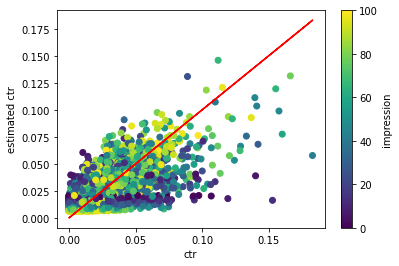

In [17]:
plt.scatter(customer_stan.ctr, customer_stan.avg_bayesian, c=customer_stan.impression, cmap='viridis', vmin=0, vmax=100)
plt.plot(customer_stan.ctr, customer_stan.ctr, color='red')
plt.colorbar(label='impression')
plt.xlabel('ctr')
plt.ylabel('estimated ctr')
plt.show()

---

Consider another model where merchants difference exists but with same trial, which is called beta-binomial regression.

$\mu_i\sim Beta(\alpha_u, \beta_u)\\
trial_i = c,\ ∀i$

With parameter tranformation: $\alpha_i=\mu_i*c,\ \beta_i=(1-\mu_i)*c$

The relation between datas and parameters:

$ctr_{ij}\sim Beta(\alpha_i, \beta_i)\\
click_{ij}\sim Bin(impression_{ij}, ctr_{ij})$

---

In [23]:
text3='''
data{
  int<lower=0> N;
  int<lower=0> M;
  int<lower=1, upper=100> type[N];
  int<lower=0> impression[N];
  int<lower=0> click[N];
}
parameters{
  vector<lower=0.01, upper=1>[M] mu;
  real<lower=0> trial;
  real<lower=0> alpha_u;
  real<lower=0> beta_u;
}
transformed parameters{
  vector[M] alpha_i;
  vector[M] beta_i;
  alpha_i = mu*trial;
  beta_i = (1-mu)*trial;
}
model{
  alpha_u~uniform(0.01, 100);
  beta_u~uniform(0.01, 100);
  mu~beta(alpha_u, beta_u);
  trial~gamma(10, 0.1);
  for(i in 1:N) {
    click[i]~beta_binomial(impression[i], alpha_i[type[i]], beta_i[type[i]]);
  }
}
'''
stan_data = {'N':data.shape[0], 'M':nmerchants, 'type': list(data[:,0].astype('int')+1), 'impression': list(data[:,2].astype('int')), 'click': list(data[:,3].astype('int'))}
posterior = stan.build(text3, data=stan_data)
fit = posterior.sample(num_chains=1, num_samples=500)
df_same_trial = fit.to_frame()

Building...



Building: 41.6s, done.Messages from stanc:
Warning in '/tmp/httpstan_i6gdw5av/model_uwba3zav.stan', line 23, column 23: Argument 100 suggests there may be parameters that are not unit scale; consider rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_i6gdw5av/model_uwba3zav.stan', line 23, column 17: Argument 0.01 suggests there may be parameters that are not unit scale; consider rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_i6gdw5av/model_uwba3zav.stan', line 23, column 2: Parameter beta_u is given a uniform distribution. The uniform distribution is not recommended, for two reasons: (a) Except when there are logical or physical constraints, it is very unusual for you to be sure that a parameter will fall inside a specified range, and (b) The infinite gradient induced by a uniform density can cause difficulties for Stan's sampling algorithm. As a consequence, we recommend soft constraints rather than hard constraints; 

In [19]:
df_same_trial.head()

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,mu.1,mu.2,mu.3,...,beta_i.91,beta_i.92,beta_i.93,beta_i.94,beta_i.95,beta_i.96,beta_i.97,beta_i.98,beta_i.99,beta_i.100
draws,,,,,,,,,,,,,,,,,,,,,
0,-24927.537044,1.000000,0.120568,5.0,31.0,0.0,24973.092559,0.061780,0.050863,0.013517,...,29.311330,29.257566,29.317336,28.617997,28.852931,29.415187,29.325427,28.253701,29.513480,29.084331
1,-24932.604968,0.978426,0.120568,5.0,31.0,0.0,24977.977854,0.038029,0.045738,0.014149,...,28.131187,28.185273,28.171607,27.672624,27.770403,28.198100,28.013232,27.234283,28.276100,27.861035
2,-24932.687603,0.999851,0.120568,5.0,31.0,0.0,24983.105084,0.043577,0.036436,0.013468,...,27.067052,26.912223,26.771894,26.569635,26.834602,27.091921,26.990930,25.602380,26.963185,26.643787
3,-24933.893555,0.919702,0.120568,3.0,13.0,1.0,24987.979546,0.052340,0.038466,0.014138,...,27.497787,27.495010,27.258357,26.950446,27.351654,27.573399,27.354085,26.139872,27.458503,27.188791
4,-24936.810450,0.831477,0.120568,2.0,7.0,1.0,24994.413300,0.054121,0.036439,0.014882,...,27.713703,27.904503,27.657610,27.387159,27.771993,27.996290,27.712666,26.627247,27.880722,27.606426


In [20]:
mu2 = df_same_trial.iloc[:,7:107].mean()
alpha_proun = df_same_trial.iloc[:,107].mean()*mu2
beta_proun = df_same_trial.iloc[:,107].mean()-alpha_proun

In [21]:
customer_stan['alpha_proun'] = alpha_proun[customer_stan.merchant_id][1]
customer_stan['beta_proun'] = beta_proun[customer_stan.merchant_id][1]
customer_stan = customer_stan.assign(avg_uni_trial = lambda df:(df.click+df.alpha_proun)/(df.impression+df.alpha_proun+df.beta_proun))
customer_stan.head()

,merchant_id,ctr,impression,click,alpha_i,beta_i,avg_stan,avg_bayesian,alpha_proun,beta_proun,avg_uni_trial
0,0,0.039671,36,3,3.548383,95.567618,0.048465,0.049453,1.189672,27.562866,0.064703
1,0,0.024390,67,3,3.548383,95.567618,0.039421,0.035534,1.189672,27.562866,0.043755
2,0,0.046245,39,4,3.548383,95.567618,0.054652,0.059820,1.189672,27.562866,0.076597
3,0,0.022885,37,1,3.548383,95.567618,0.033415,0.023881,1.189672,27.562866,0.033302
4,0,0.039725,88,3,3.548383,95.567618,0.034996,0.029844,1.189672,27.562866,0.035885


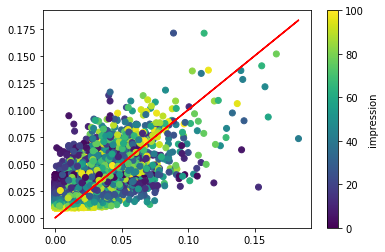

In [22]:
plt.scatter(customer_stan.ctr, customer_stan.avg_uni_trial, c=customer_stan.impression, cmap='viridis', vmin=0, vmax=100)
plt.plot(customer_stan.ctr, customer_stan.ctr, color='red')
plt.colorbar(label='impression')
plt.show()